In [1]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import json

2023-07-18 17:39:31.017394: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 17:39:31.222727: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 17:39:31.224579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 17:39:32.299171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [70]:
import json
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"
text_key = "preprocessedText"
docs = []
larr1 = []
with open(dataset_path + "ROTVRSV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        docs.append(d[text_key])
        larr1.append(d["label"])

tdocs = []
larr2 = []
with open(dataset_path + "DENV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        tdocs.append(d[text_key])
        larr2.append(d["label"])

        # Tokenize the documents.

from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
for idx in range(len(tdocs)):
    tdocs[idx] = tdocs[idx].lower()  # Convert to lowercase.
    tdocs[idx] = tokenizer.tokenize(tdocs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
tdocs = [[token for token in doc if not token.isnumeric()] for doc in tdocs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]
tdocs = [[token for token in doc if len(token) > 1] for doc in tdocs]

# Compute bigrams.
from gensim.models import Phrases

delim = '_'
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=1, delimiter=delim)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if delim in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
for idx in range(len(tdocs)):
    for token in bigram[tdocs[idx]]:
        if delim in token:
            # Token is a bigram, add to document.
            tdocs[idx].append(token)

print(len(docs))
print(docs[0][:500])
print(len(tdocs))
print(tdocs[0][:500])

22996
['carbocisteine', 'inhibit', 'respiratory', 'syncytial', 'virus', 'infection', 'human', 'tracheal', 'epithelial', 'cell', 'it', 'be', 'suggest', 'carbocisteine', 'may', 'inhibit', 'rs', 'virus', 'infection', 'reduce', 'expression', 'icam', 'rs', 'virus', 'receptor', 'it', 'may', 'also', 'modulate', 'airway', 'inflammation', 'rsirus', 'infection', 'respiratory_syncytial', 'tracheal_epithelial', 'it_be', 'rs_virus', 'expression_icam', 'rs_virus', 'airway_inflammation']
8679
['vitro', 'effect', 'human', 'cathelicidin', 'antimicrobial', 'peptide', 'll', 'dengue', 'virus', 'type', 'vitro', 'experiment', 'silico', 'analysis', 'suggest', 'll', 'inhibit', 'dengue', 'virus', 'type', 'denv', 'infection', 'replication', 'vero', 'e6', 'cell', 'bind', 'protein', 'human_cathelicidin', 'antimicrobial_peptide', 'dengue_virus', 'vitro_experiment', 'silico_analysis', 'll_inhibit', 'dengue_virus', 'denv_infection', 'vero_e6']


In [71]:
in_memory_file1 = open('/tmp/t1', 'w')
for i in range(len(docs)):
    in_memory_file1.write(json.dumps({text_key: ' '.join(docs[i]), "label": larr1[i]}, ensure_ascii=True))
    in_memory_file1.write('\n')
in_memory_file1.close()
in_memory_file1 = open('/tmp/t1', 'r')
#in_memory_file1 = open(dataset_path + "DENV")
in_memory_file2 = open('/tmp/t3', 'w')
for i in range(len(tdocs)):
    in_memory_file2.write(json.dumps({text_key: ' '.join(tdocs[i]), "label": larr2[i]}, ensure_ascii=True))
    in_memory_file2.write('\n')
    if i==500:
        print(json.dumps({text_key: ' '.join(tdocs[i]), "label": larr2[i]}))
in_memory_file2.close()
in_memory_file2 = open('/tmp/t3', 'r')

{"preprocessedText": "acute kidney injury associate dengue virus infection review review narrative review aim update epidemiology aki associate dengue elucidate main pathophysiological mechanism discuss useful information prevention management ofaki patient dengue acute_kidney dengue_virus review_narrative review_aim pathophysiological_mechanism useful_information prevention_management", "label": "0"}


In [72]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

trds = pd.read_json(in_memory_file1,
                 dtype={text_key: str, "label": str},
                lines=True
                 )
teds = pd.read_json(in_memory_file2,
                 dtype={text_key: str, "label": str},
                lines=True
                 )
tr_ds = tfdf.keras.pd_dataframe_to_tf_dataset(trds, label="label")
te_ds = tfdf.keras.pd_dataframe_to_tf_dataset(teds, label="label")

dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"
with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()

In [73]:
def prepare_dataset1(example, label):
    return {"sentence" : tf.strings.split(example[text_key])}, label

def prepare_dataset2(s):
    m = json.loads(s)
    sp = tf.strings.split(m["preprocessedText"])
#    print(sp)
#    m["prep"] = tf.RaggedTensor.from_tensor(sp, ragged_rank=1)
#    m["prep"] = tf.constant(sp)
    return m

train_ds = tr_ds.map(prepare_dataset1)
test_ds = te_ds.map(prepare_dataset1)
#for features, label in test_ds:
#    print("features:", features)
#    print("label:", label)
#    break
    
test_cases = list(map(prepare_dataset2, test_lines))

In [74]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=1000, verbose=2, num_threads=3)

# Train the model.
model_1.fit(x=train_ds, batch_size=None)

<IPython.core.display.Javascript object>

Use /tmp/tmpglageop1 as temporary training directory


Reading training dataset...
Training tensor examples:
Features: {'sentence': tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64))}
Label: Tensor("data_2:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'sentence': SemanticTensor(semantic=<Semantic.CATEGORICAL_SET: 4>, tensor=tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64)))}
Training dataset read in 0:00:00.183608. Found 22996 examples.
Training model...


2023-07-18 20:26:58.180706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]
[INFO 23-07-18 20:26:58.3652 CEST kernel.cc:773] Start Yggdrasil model training
[INFO 23-07-18 20:26:58.3652 CEST kernel.cc:774] Collect training examples
[INFO 23-07-18 20:26:58.3652 CEST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-07-18 20:26:58.3658 CEST kernel.cc:393] Number of batches: 23
[INFO 23-

[INFO 23-07-18 20:33:31.3440 CEST random_forest.cc:802] Training of tree  193/1000 (tree index:192) done accuracy:0.846582 logloss:0.381836
[INFO 23-07-18 20:33:42.7524 CEST random_forest.cc:802] Training of tree  198/1000 (tree index:197) done accuracy:0.846539 logloss:0.38162
[INFO 23-07-18 20:33:53.6396 CEST random_forest.cc:802] Training of tree  203/1000 (tree index:202) done accuracy:0.846234 logloss:0.381592
[INFO 23-07-18 20:34:06.4087 CEST random_forest.cc:802] Training of tree  209/1000 (tree index:208) done accuracy:0.846886 logloss:0.381453
[INFO 23-07-18 20:34:19.3246 CEST random_forest.cc:802] Training of tree  215/1000 (tree index:214) done accuracy:0.846452 logloss:0.38135
[INFO 23-07-18 20:34:32.1344 CEST random_forest.cc:802] Training of tree  221/1000 (tree index:220) done accuracy:0.846539 logloss:0.381346
[INFO 23-07-18 20:34:44.8770 CEST random_forest.cc:802] Training of tree  227/1000 (tree index:226) done accuracy:0.846712 logloss:0.381141
[INFO 23-07-18 20:34:5

[INFO 23-07-18 20:45:11.2017 CEST random_forest.cc:802] Training of tree  544/1000 (tree index:543) done accuracy:0.849452 logloss:0.379448
[INFO 23-07-18 20:45:21.4276 CEST random_forest.cc:802] Training of tree  549/1000 (tree index:548) done accuracy:0.849148 logloss:0.379417
[INFO 23-07-18 20:45:33.9050 CEST random_forest.cc:802] Training of tree  555/1000 (tree index:554) done accuracy:0.84893 logloss:0.379431
[INFO 23-07-18 20:45:45.8900 CEST random_forest.cc:802] Training of tree  561/1000 (tree index:560) done accuracy:0.849061 logloss:0.379409
[INFO 23-07-18 20:45:57.5001 CEST random_forest.cc:802] Training of tree  567/1000 (tree index:566) done accuracy:0.84967 logloss:0.379353
[INFO 23-07-18 20:46:09.0106 CEST random_forest.cc:802] Training of tree  573/1000 (tree index:572) done accuracy:0.850061 logloss:0.379368
[INFO 23-07-18 20:46:20.6372 CEST random_forest.cc:802] Training of tree  579/1000 (tree index:578) done accuracy:0.849713 logloss:0.37928
[INFO 23-07-18 20:46:32

[INFO 23-07-18 20:56:40.7727 CEST random_forest.cc:802] Training of tree  894/1000 (tree index:893) done accuracy:0.85067 logloss:0.376986
[INFO 23-07-18 20:56:52.8694 CEST random_forest.cc:802] Training of tree  900/1000 (tree index:899) done accuracy:0.850844 logloss:0.376934
[INFO 23-07-18 20:57:04.5511 CEST random_forest.cc:802] Training of tree  906/1000 (tree index:905) done accuracy:0.8508 logloss:0.376972
[INFO 23-07-18 20:57:16.6800 CEST random_forest.cc:802] Training of tree  912/1000 (tree index:911) done accuracy:0.851452 logloss:0.376939
[INFO 23-07-18 20:57:28.7919 CEST random_forest.cc:802] Training of tree  918/1000 (tree index:917) done accuracy:0.851452 logloss:0.376903
[INFO 23-07-18 20:57:40.3947 CEST random_forest.cc:802] Training of tree  924/1000 (tree index:923) done accuracy:0.852409 logloss:0.3769
[INFO 23-07-18 20:57:51.8202 CEST random_forest.cc:802] Training of tree  930/1000 (tree index:929) done accuracy:0.852148 logloss:0.37688
[INFO 23-07-18 20:58:03.38

Model trained in 0:33:18.508716
Compiling model...


2023-07-18 21:00:17.149000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]


Model compiled.


In [75]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, batch_size=None)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

2023-07-19 08:43:30.492649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8679]
	 [[{{node Placeholder/_1}}]]


9/9 [==============================] - 8s 909ms/step - loss: 0.0000e+00 - accuracy: 0.9010
BinaryCrossentropyloss: 0.0
Accuracy: 0.9010254740715027


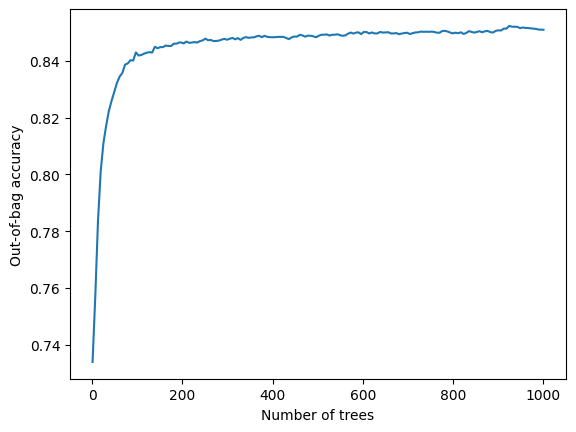

In [76]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

In [77]:
p = model_1.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = test_cases[i]["label"] == '1'
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

9/9 [==============================] - 8s 853ms/step
cut: 0.25, acc: 0.6163152436916696, prec: 0.40212497748964526, rec: 0.9955416852429781, f1: 0.5728578758337608
cut: 0.3, acc: 0.7052655835925797, prec: 0.46697420842944015, rec: 0.992866696388765, f1: 0.6351968054763263
cut: 0.35, acc: 0.7762415024772439, prec: 0.5366090975431769, rec: 0.9835042353990192, f1: 0.6943657538558389
cut: 0.39999999999999997, acc: 0.8261320428620809, prec: 0.6016620498614959, rec: 0.9683459652251449, f1: 0.7421834956432598
cut: 0.44999999999999996, acc: 0.870491992164996, prec: 0.6793844180827188, rec: 0.9447168970129292, f1: 0.7903767251025737
cut: 0.49999999999999994, acc: 0.9010254637631063, prec: 0.7568671121009651, rec: 0.9090503789567543, f1: 0.826007696981973
cut: 0.5499999999999999, acc: 0.9164650305334716, prec: 0.8288561525129983, rec: 0.8528756130182791, f1: 0.8406943528894749
cut: 0.5999999999999999, acc: 0.917732457656412, prec: 0.8855269793242562, rec: 0.7828800713330362, f1: 0.83104590629436

In [15]:
cut = 55
N = len(p)
with open("/home/ralf//IdeaProjects/LitBall-training/pred.json", "w") as file:
    for c in np.arange(0., .5, .05):
        s = 0
        t = 0
        for i in range(N):
            tru = test_cases[i]["label"] == '1'
            val = int((p[i]+0.005) * 100)
            pred = False
            if val > cut:
                pred = True
            elif val > 100*c:
                s = s+1
                if tru:
                    t = t+1
        print("c: {}, n = {}, tru: {}".format(c, s, t))

c: 0.0, n = 6525, tru: 378
c: 0.05, n = 6396, tru: 378
c: 0.1, n = 5885, tru: 377
c: 0.15000000000000002, n = 4983, tru: 376
c: 0.2, n = 4009, tru: 374
c: 0.25, n = 3139, tru: 368
c: 0.30000000000000004, n = 2379, tru: 351
c: 0.35000000000000003, n = 1765, tru: 323
c: 0.4, n = 1261, tru: 281
c: 0.45, n = 785, tru: 209
